In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import xmltodict
from tqdm import tqdm
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
import gensim.downloader
import spacy
nlp = spacy.load("en_core_web_lg")
import numpy as np
import sklearn
import sklearn.decomposition
import sklearn.manifold
import matplotlib.pyplot as plt
import json
import string
import ast
import os
import re
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics.pairwise import cosine_similarity 
from nltk.corpus import words
from gensim.models import KeyedVectors
import gensim.downloader as api
from time import perf_counter
import warnings
warnings.simplefilter('ignore')
import wordninja
from gensim.test.utils import datapath 
import re
import string, re
# import cython
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from random import seed, sample
from ksvd import ApproximateKSVD #pip or conda install ksvd #this is key!
from numpy.linalg import norm
from itertools import product
import statistics
from collections import Counter
import math
from pandarallel import pandarallel
pandarallel.initialize(progress_bar = True)
tqdm.pandas()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [154]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Preprocessing Words 

In [155]:
def remove_non_english_words(text):
    # Remove non-letter characters and split the text into words
    words = re.sub(r'[^a-zA-Z ]', '', text).split()

    # Define a regular expression to match non-ASCII characters
    non_english_pattern = re.compile(r'[^\x00-\x7F]+')

    # Filter out words that contain non-ASCII characters
    english_words = [word for word in words if not non_english_pattern.search(word)]

    # Join the remaining words into a single string and return it
    return ' '.join(english_words)

In [156]:
#### 

def joinwords(y): 
    """
    Converts 'migrant worker' to one token 
    
    Input: 
        y - list of strings
    
    Returns: 
        string with migrant worker replaced
    """
    if type(y) == float: 
        y = str(y)
    if 'migrant worker' in y:
        return '. '.join([x.replace('migrant worker', 'migrantworker') for x in y.split('. ') if 'migrant worker' in x])
    elif 'migrant workers' in y: 
        return '. '.join([x.replace('migrant workers', 'migrantworker') for x in y.split('. ') if 'migrant workers' in x])
    elif 'little india' in y: 
        return '. '.join([x.replace('little india', 'littleindia') for x in y.split('. ') if 'little india' in x])
    elif 'little india riot' in y: 
        return '. '.join([x.replace('little india riot', 'littleindiariot') for x in y.split('. ') if 'little india riot' in x])
    else: 
        return y

In [ ]:
def stop_and_lower(x): 
  return [t.lower() for t in x]
  
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [ ]:
def extract_from_list(x): 
    if x:
        for sentence in x: 
            return str(sentence)
    else: 
        return None

punctuation = list(string.punctuation)
def remove_punctuation(x): 
    norm = []
    for token in x: 
        if token not in punctuation: 
            norm.append(token)
    return norm

In [ ]:
def replace_words(sent):
     new_list = [] 
     for word in sent:
        if nlp.vocab.has_vector(word):
            new_list.append(word)
        else:
            new_list.extend(wordninja.split(word))

     return new_list

In [ ]:
tqdm.pandas()
data['pre_text'] = data['Text'].progress_apply(lambda x: x.lower())
data['pre_text'] = data['pre_text'].progress_apply(lambda x: remove_non_english_words(x))
data['pre_text'] = data['pre_text'].progress_apply(lambda x: joinwords(x))
data['tokenized'] = data['pre_text'].progress_apply(lambda x: word_tokenize(x))
data['tokenized'] = data['tokenized'].progress_apply(lambda x: remove_punctuation(x))
data['normalized'] = data['tokenized'].progress_apply(lambda x: normalizeTokens(x))
data['normalized'] = data['normalized'].progress_apply(lambda x: [x])

## Discourse Atoms

In [ ]:
tqdm.pandas()
data['pre_text'] = data['Text'].progress_apply(lambda x: x.lower())
data['pre_text'] = data['pre_text'].progress_apply(lambda x: remove_non_english_words(x))
data['pre_text'] = data['pre_text'].progress_apply(lambda x: joinwords(x))
data['tokenized'] = data['pre_text'].progress_apply(lambda x: word_tokenize(x))
data['tokenized'] = data['tokenized'].progress_apply(lambda x: remove_punctuation(x))
data['normalized'] = data['tokenized'].progress_apply(lambda x: normalizeTokens(x))
data['normalized'] = data['normalized'].progress_apply(lambda x: [x])

100%|██████████| 272088/272088 [00:00<00:00, 1021526.50it/s]


##############################################################################################################################

### Loading Files/Models ###

In [54]:
### The overall dataframe
parl_df = pd.read_csv('/Users/Administrator/Desktop/UChicago/Thesis/files/parldata.csv')

In [8]:
### Dataframe only containing rows that have 'migrant worker', 'migrant workers', 'little india', and 'little india riot'
filtered_parl_df = pd.read_parquet('/Users/Administrator/Desktop/UChicago/Thesis/files/parl_array.parquet')

In [ ]:
### Loading overall parliamentary model
parl_model = Word2Vec.load('/Users/Administrator/Desktop/UChicago/Thesis/models/thesis_model1.model')
### Loading models trained on corpus before and after the riot
model_pre = Word2Vec.load('/Users/Administrator/Desktop/UChicago/Thesis/models/thesis_model_preriot.model')
model_post = Word2Vec.load('/Users/Administrator/Desktop/UChicago/Thesis/models/thesis_model_postriot.model')

In [55]:
parl_df['clean'] = parl_df['clean'].parallel_apply(lambda x: ast.literal_eval(x))
parl_df['clean_new'] = parl_df['clean'].parallel_apply(lambda x: replace_words(x))
parl_df.drop(columns = ['Unnamed: 0.3', 'Unnamed: 0.1', 'Unnamed: 0.2', 'Unnamed: 0'], inplace=True)
parl_df['raw_text'] = parl_df['clean_new'].parallel_apply(lambda x: ' '.join(x))
parl_df.head()
parl_df.drop_duplicates(subset = 'raw_text')

In [195]:
parl_df['normalized_sents'] = parl_df['normalized_sents'].parallel_apply(lambda x: ast.literal_eval(x))

##############################################################################################################################

In [196]:
preriot = parl_df[parl_df['year'].isin([2012, 2013])]

In [199]:
pretrained_path = "/Users/Administrator/Downloads/GoogleNews-vectors-negative300.bin.gz"
model_2 = KeyedVectors.load_word2vec_format(pretrained_path, binary=True)
sentences = preriot['normalize_sents'].sum()
model_pre = Word2Vec(vector_size = 300, min_count=2)
model_pre.build_vocab(sentences)
total_examples = model_pre.corpus_count
model_pre.build_vocab([list(model_2.index_to_key)], update = True)
model_pre.wv.vectors_lockf = np.ones(len(model_pre.wv))
model_pre.wv.intersect_word2vec_format(pretrained_path, lockf=1.0, binary=True)
model_pre.train(sentences, total_examples = total_examples, epochs=3)

(2488196, 2574321)

In [ ]:
#### TRAIN MODEL:

#n_comp: Number of topics (i.e., atoms, or dictionary elements)
#n_nonzeros: Number of nonzero coefficients to target (how many atoms each word can load onto)
            
def do_aksvd(w2v, n_comp, n_nonzeros, save=False, savelocation='/Users/Administrator/Desktop/UChicago/Thesis/'): 
    #https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms 
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) #also may adjuste n iter which is default at 10, and tolerance for error which is default at  tol=1e-6 #n_components is number of discourse atoms, since vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(w2v.wv.vectors).components_ # Dictionary is the matrix of discourse atoms. 
    alpha_t = aksvd_t.transform(w2v.wv.vectors) #get the alphas, which are the "weights" of each word on a discourse atoms

    if save==True:
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_aksvd_nvdrsdf20','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' +str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary_nvdrsdf20','wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_alpha_nvdrsdf20','wb')
        pickle.dump(alpha_t,outfile)
        outfile.close()
    return(dictionary_t, alpha_t)

In [ ]:
def reconst_qual(w2v, dictionary_mat, alpha_mat):
    #reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat) #reconstruct word vectors and add back in mean(?). but note that reconstructed norm is still around 0-1, not 1, is that an issue?
    #e1 = norm(w2v.wv.vectors - reconstructed) #total reconstruction error, larger means MORE error. norm as specified here takes frobenius norm of error matrix.


    #total VARIANCE in the data: sum of squares 
    squares3= w2v.wv.vectors-np.mean(w2v.wv.vectors, axis=1).reshape(-1,1) #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sst3= np.sum([i.dot(i) for i in squares3] ) #same as below

    sst3= np.sum(np.square(squares3))


    #total sum of squared ERRORS/residuals
    e3= [reconstructed[i]-w2v.wv.vectors[i] for i in range(0,len(w2v.wv.vectors))]  #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sse3= np.sum([i.dot(i) for i in e3] ) #same as below
    sse3= np.sum(np.square(e3))

    #R^2: 1- (SSE / SST )
    r2= 1- (sse3 /  sst3) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error


    #compute root mean square error
    rmse=  math.sqrt(np.mean(np.square(e3)))



    return(sse3, rmse, r2) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error

In [ ]:
#topic diversity (% unique words among total closest 25 words to each atom)
def topic_diversity(w2vmodel, dictionary_mat, top_n=25):

    topwords=[] #list of list, each innter list includes top N words in that topic

    for i in range(0, len(dictionary_mat)): #set to number of total topics
        topwords.extend([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary_mat[i],topn=top_n)]) #set for top N words 
        #print(w2vmodel.wv.similar_by_vector(dictionary[i],topn=N))

    uniquewords= set(topwords)
    diversity = len(uniquewords)/len(topwords)
    return(diversity)

In [ ]:
def coherence_centroid(w2vmodel, dictionary_mat, top_n): #eventually, combine with topic diversity into a class, since redundancy. this is based on: Aletras, Nikolaos, and Mark Stevenson. "Evaluating topic coherence using distributional semantics." Proceedings of the 10th International Conference on Computational Semantics (IWCS 2013)–Long Papers. 2013.
    minsim= []
    meansim=[]
    for k in dictionary_mat: #set to number of total topics
        words= [i[0] for i in w2vmodel.wv.similar_by_vector(k,topn=25)]
        topwordsvecs= [w2vmodel.wv[i] for i in words] #vecs for top closest words
        medvec= np.mean(topwordsvecs, axis=0) #using median rather than mean, since then less swayed by outliers
        sims= [abs(cosine_similarity(i.reshape(1,-1), medvec.reshape(1,-1))[0]) for i in topwordsvecs]
        minsim.append(np.min(sims))
        meansim.append(np.mean(sims))
    return(np.mean(meansim)) #average min, and average mean


def coherence_pairwise(w2vmodel, dictionary_mat, top_n): #eventually, combine with topic diversity into a class, since redundancy. this is based on: Aletras, Nikolaos, and Mark Stevenson. "Evaluating topic coherence using distributional semantics." Proceedings of the 10th International Conference on Computational Semantics (IWCS 2013)–Long Papers. 2013.
    #minsim= []
    meansim=[] #list of coherence of atoms in the model
    for k in dictionary_mat: #set to number of total topics
        words= [i[0] for i in w2vmodel.wv.similar_by_vector(k,topn=25)]
        topwordsvecs= [w2vmodel.wv[i] for i in words] #vecs for top closest words
        combo_sims= [abs(cosine_similarity(l[0].reshape(1,-1), l[1].reshape(1,-1))[0])[0] for l in combinations(topwordsvecs, 2)]
        #medvec= np.mean(topwordsvecs, axis=0) #using median rather than mean, since then less swayed by outliers
        #sims= [abs(cosine_similarity(i.reshape(1,-1), medvec.reshape(1,-1))[0]) for i in combos]
        #minsim.append(np.min(sims))
        meansim.append(np.mean(combo_sims)) #append coherence of this atom
    return(np.mean(meansim)) #mean of coherences of atoms in the model

In [ ]:
def find_best_topics(start_topics, num_topics, model):
    topics = {}
    print('started')
    for topic in tqdm(range(start_topics, num_topics)): 
        dictionary_parl, alpha_parl = do_aksvd(model, topic, 5, save=False)
        sse3, rmse, r2 = reconst_qual(model, dictionary_parl, alpha_parl)
        print(r2, topic)
        if topic not in topics: 
            topics[topic] = [0, 0, 0]
        topics[topic] = sse3, rmse, r2
    
    return topics

### Grid Search 

In [ ]:
from __future__ import division
import pandas as pd
import math
from gensim.models import coherencemodel
import pickle
from scipy.linalg import norm
from sklearn.preprocessing import normalize
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import os
from itertools import combinations
import numpy as np
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec, KeyedVectors
from random import seed, sample
import seaborn as sns
from ksvd import ApproximateKSVD 
import time 

ntopics= []
nonzeros = []
cohere_pairwise= []
div=[]
sse= []
rmse =[]
r2=[]
currentmodel = parl_model1
st = time.time()
for i in tqdm(range(2050, 4000, 50)): 
    for j in tqdm([5]):
        dictionary_parl, gamma_parl = do_aksvd(currentmodel, i, j, save=False) #varying hyperparameters
        cohere_pairwise.append(coherence_pairwise(currentmodel, dictionary_parl, top_n=25))
        div.append(topic_diversity(currentmodel, dictionary_parl, top_n=25))
        rec= reconst_qual(currentmodel, dictionary_parl, gamma_parl)
        sse.append(rec[0])
        rmse.append(rec[1])
        r2.append(rec[2])
        ntopics.append(i)
        nonzeros.append(j)

et = time.time()
print(et-st)

In [ ]:
quality_results1 = pd.DataFrame(data={'Components_Topics': ntopics,'Nonzeros': nonzeros,
                'CohereCossim_top25_mean': cohere_pairwise, 'Diversity_top25': div, 
                  'SSE': sse,'RMSE': rmse, 'R2': r2})

In [ ]:
sns.set(style="ticks")
plt=sns.lineplot(x="Components_Topics", y="R2", hue="Nonzeros", data=quality_results1, legend='full', sort=True)
plt.legend(bbox_to_anchor=(1.3, .5),loc='center right')#, borderaxespad=0.) 
#plt.set(ylim=(.67, .85))
#plt.set(xlim=(0,550))

In [ ]:
#topic diversity (% unique words among total closest 25 words to each atom)
def topic_diversity(w2v, dictionary_mat, top_n=25):

    topwords=[] #list of list, each innter list includes top N words in that topic

    for i in range(0, len(dictionary_mat)): #set to number of total topics
        topwords.extend([i[0] for i in w2v.wv.similar_by_vector(dictionary_mat[i],topn=top_n)]) #set for top N words 
        #print(w2v.wv.similar_by_vector(dictionary[i],topn=N))

    uniquewords= set(topwords)
    diversity = len(uniquewords)/len(topwords)
    return(diversity)

In [ ]:
dictionary_parl, alpha_parl = do_aksvd(parl_model, 150, 5, save=False)

##################################################################################################################################################################

### Interpreting Topics

In [6]:
ref_dir = '/Users/Administrator/Desktop/UChicago/Thesis/models/'
temp_save = '/Users/Administrator/Desktop/UChicago/Thesis/models/'
tdm_loc = '/Users/Administrator/Desktop/UChicago/Thesis/models/'
df_dir = '/Users/Administrator/Desktop/UChicago/Thesis/files/'
model_name = 'thesis_model1'
df = 'parl_array'
name = 'parl'

In [9]:
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
alpha = np.load(df_dir + f'alpha_{name}.npy')
dictionary = np.load(df_dir + f'dictionary_{name}.npy')
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
w2v = gensim.models.Word2Vec.load(tdm_loc + f'{model_name}.model')
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
xDF = filtered_parl_df ## see notebook 1
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
## Get tokens in the model vocab
m_vocab = w2v.wv.index_to_key
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
## Get tokens in the corpus vocab, where xDF is a DataFrame where each row is a text chunk and
## there's a column where that text has been normalized with the same process that was used to
## normalize the texts on which the w2v model was trained.

## The texts here are the texts that are being analyzed, not the training texts.
corpus_vocab = list(set([x for y in xDF['text'].values.tolist() for x in y]))
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---

In [103]:
### Get the top N closest words to a topic from the model (i.e., tokens in the model) and 
### from the corpus (i.e., tokens that are both in the corpus and in the model)
### Get the cosine similarity of the topic to those words
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
def get_atom_dict(model, atom_dict, corpus_vocab, max_check=1000, top_n=25):
    out_list = []
    vectors = model.wv
    model_vocab = model.wv.index_to_key
    present_vocab = [x for x in tqdm(corpus_vocab) if x in model_vocab]
    for i, atom in tqdm(enumerate(atom_dict)):
        DF = pd.DataFrame()
        idx = 0
        neighbors = vectors.similar_by_vector(atom, topn=max_check)
        corporal_neighbors = [(k,v) for k,v in neighbors if k in present_vocab]
        for k,v in neighbors[:top_n]:
            DF.loc[idx, 'Topic'] = i           
            DF.loc[idx, 'm_key'] = k
            DF.loc[idx, 'm_val'] = v
            idx+=1
        idx = 0
        for k,v in corporal_neighbors[:top_n]:
            DF.loc[idx, 'Topic'] = i        
            DF.loc[idx, 'c_key'] = k
            DF.loc[idx, 'c_val'] = v
            idx+=1
        for val in DF.values.tolist():
            out_list.append(val)
    DF = pd.DataFrame(out_list, columns=['Topic','m_key','m_val','c_key','c_val'])
    DF['Topic'] = DF['Topic'].apply(lambda x: int(x))
    DF['topic_tag'] = DF['Topic'].apply(lambda x: f'topic_{str(x).zfill(4)}')            
    return DF
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---

In [31]:
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
TN = 25
AA = get_atom_dict(w2v, dictionary, corpus_vocab, top_n=TN)
AA.to_csv(ref_dir + f'{name} + atom_key_words.csv', index=False)
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
## You can now use this DF to label the atoms and figure out what each atom is capturing.
# --- --- --- --- --- --- --- z--- --- --- --- --- --- --- --- ---

NameError: name 'get_atom_dict' is not defined

In [32]:
AA = pd.read_csv(ref_dir + f'{name} + atom_key_words.csv')

---
---

### Getting 'document' level embeddings according to selection criteria

In [ ]:
xDF.rename(columns = {'clean_new': 'text'}, inplace=True)

In [ ]:
def get_slice_df(df, group_by):
    # Group by year and concatenate the string lists
    new_df = df.groupby('year')['text'].apply(lambda x: ', '.join([str(i) for i in x])).reset_index()

    return new_df

In [ ]:
### For a given text chunk, get the document array within the model.
def get_doc_array(model, model_vocab, list_of_tokens):    
    embeddings = model.wv
    if type(list_of_tokens[0])==list:
        words = list(set([x for y in list_of_tokens for x in y]))
    else:
        words = list_of_tokens
    words = [w for w in words if w in model_vocab]
    if len(words)>1:
        doc_array = np.mean(embeddings[words], axis=0)
    else:
        doc_array = embeddings[words[0]]
    return doc_array

In [ ]:
### Use previous two functions to get the document embedding.
### Pass a list of column as karg to keep them in the output DF.
### Set 'group_by' to False to get the embedding for each row in the DF.
def get_doc_embeddings(df, group_by, model=w2v, model_vocab=m_vocab, **kargs):
    if group_by!=False:
        DF = get_slice_df(df, group_by)
    else:
        keep = kargs['keep'] + ['year'] + ['text']
        DF = df[keep].copy()
    DF['doc_array'] = DF['text'].parallel_apply(lambda x: get_doc_array(w2v, m_vocab, x))
    return DF

In [ ]:
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
## Example use:
year_DF = get_doc_embeddings(xDF, ['year']) ## would return one embedding for all rows attributed to the
## same author under column 'year'

k_list = [] ## list of metadata columns
sents_DF = get_doc_embeddings(xDF, False, keep=k_list) ## would return a row by row embedding, I would
## recomend keeping all the metadata columns in this instance; see 'k_list'

## These can take a while to run, which is why we're doing them ahead of time and saving them out.
## That way we can iterate without too much trouble.
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
year_DF.to_pickle(f'{ref_dir}year_DF_filtered + {name}.pkl')
sents_DF.to_pickle(f'{ref_dir}sents_DF_filtered + {name}.pkl')
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---

Process ForkPoolWorker-109:
Process ForkPoolWorker-101:
Process ForkPoolWorker-106:


KeyboardInterrupt: 

Process ForkPoolWorker-110:
Process ForkPoolWorker-111:
Process ForkPoolWorker-108:
Process ForkPoolWorker-112:
Process ForkPoolWorker-107:


In [ ]:
year_DF = pd.read_pickle(f'{ref_dir}year_DF + {name}.pkl')
sents_DF = pd.read_pickle(f'{ref_dir}sents_DF + {name}.pkl')

---
---

### Get Similarities b/w text chunks and atoms

In [ ]:
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
atom_dict = {f'topic_{str(i).zfill(4)}':dictionary[i] for i in range(len(dictionary))}
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
## Use the 'doc' arrays created above to create dictionaries with one column as key. and doc arrays as values.
year_dict = year_DF.set_index('year').to_dict()['doc_array']
sents_dict = sents_DF.reset_index().set_index('index').to_dict()
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---

In [ ]:
tqdm.pandas()
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
def calc_cosine(A, B):
    return cosine_similarity(A, B)
    
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
def get_cosine_similarity_DF(arr_dict_1, arr_dict_2, sent=False):
    if sent:
        arr_dict_2 = arr_dict_2['doc_array']
        combos = list(product(arr_dict_1.keys(), arr_dict_2.keys()))
    else:
         combos = list(product(arr_dict_1.keys(), arr_dict_2.keys()))
    DF = pd.DataFrame(index=combos)
    DF.index.name = 'combo'
    DF = DF.reset_index()
    DF['id1'] = DF['combo'].parallel_apply(lambda x: x[0])
    DF['id2'] = DF['combo'].parallel_apply(lambda x: x[1])
    DF['cosine_similarity'] = DF['combo'].parallel_apply(
            lambda x: calc_cosine(arr_dict_1[x[0]].reshape(1, -1), arr_dict_2[x[1]].reshape(1, -1))[0][0])
    DF = DF[['id1','id2','cosine_similarity']]
    return DF


In [ ]:
tqdm.pandas()
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
author_atom_sims = get_cosine_similarity_DF(atom_dict, year_dict)
sents_atom_sims = get_cosine_similarity_DF(atom_dict, sents_dict, sent=True)
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
author_atom_sims.to_pickle(f'{ref_dir}author_atom_sims_+{name}.pkl')
sents_atom_sims.to_pickle(f'{ref_dir}sents_atom_sims_+{name}.pkl')
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---

In [ ]:
author_atom_sims = pd.read_pickle(f'{ref_dir}author_atom_sims_+ {name}.pkl')
sents_atom_sims = pd.read_csv(f'{ref_dir}sents_atom_sims_+{name}.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Administrator/Desktop/UChicago/Thesis/models/author_atom_sims + parl.pkl'

In [ ]:
author_atom_sims = pd.read_pickle(f'{ref_dir}author_atom_sims_+{name}.pkl')
sents_atom_sims = pd.read_pickle(f'{ref_dir}sents_atom_sims_+{name}.pkl')

In [ ]:
## Get similarities between atoms:
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
tt_sims = get_cosine_similarity_DF(atom_dict, atom_dict)
tt_sims = tt_sims[~(tt_sims['id1']==tt_sims['id2'])]
tt_sims['check_string'] = tt_sims.apply(
    lambda row: ''.join(sorted([row['id1'], row['id2']])), axis=1)
tt_sims = tt_sims.drop_duplicates('check_string')
tt_sims = tt_sims[['id1','id2','cosine_similarity']]
tt_sims = tt_sims.sort_values('cosine_similarity')
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
tt_sims.to_pickle(f'{ref_dir}tt_sims.pkl')
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---

In [ ]:
tt_sims = pd.read_pickle(f'{ref_dir}tt_sims.pkl')

In [ ]:
## For a similarity DF, add a column indicating how much above or below the median similarity 
## the similarity for that row is, returns both raw and as a percentage:
def check_sims_against_median(df):
    sims = df['cosine_similarity'].values.tolist()
    rang = max(sims) - min(sims)
    med = statistics.median(sims)
    df['dif_raw'] = df['cosine_similarity'].parallel_apply(lambda x: x-med)
    df['dif_per'] = df['dif_raw'].parallel_apply(lambda x: round((x/rang)*100),2)
    return df
## You can then sort by 'dif_raw' or 'dif_per' and take .head(n) or .tail(n) to get the n most or least similar.

In [ ]:
sents_atom_sims_1 = check_sims_against_median(sents_atom_sims_1)


In [ ]:
def calculate_similarity(atom_dict, model):
    avg = []
    non_zero = []
    vectors = model.wv.vectors
    for key, atom_array in tqdm(atom_dict.items()):
        cos = np.dot(vectors, atom_array) / (np.linalg.norm(vectors, axis=1) * np.linalg.norm(atom_array))
        avg.append(np.mean(cos))
        print(np.mean(cos))
        if np.mean(cos) > 0.1e-5:
            non_zero.append(key)

    return avg, non_zero
        

In [ ]:
def calculate_similarity(atom_dict, model):
    vectors = model.wv.vectors
    norms = np.linalg.norm(vectors, axis=1)
    avg = np.dot(atom_dict.values(), vectors.T) / (np.linalg.norm(atom_dict.values(), axis=1, keepdims=True) * norms[None,:])
    avg = np.nanmean(avg, axis=1)

    non_zero_indices = np.nonzero(avg)[0]
    non_zero = [list(atom_dict.keys())[i] for i in non_zero_indices]

    return avg, non_zero

### Frequency Weights

The first input to SIF embeddings is an estimate of the frequency weights (based on probabilites) for each word in the corpus. Compute this here.

This will naturally downweight stopwords when we compute a sentence embedding. It requires the raw text data of the corpus.
Either train a dictonary of weights (1), or upload a saved dictionary (2).

In [10]:
def get_freq_dict(w2v, weight_a=0.001):
    vocab = w2v.wv.key_to_index
    freq_dictionary = {word: w2v.wv.get_vecattr(word, "count") for word in vocab} 
    total = sum(freq_dictionary.values())
    freq_dictionary = {word: weight_a / (weight_a + (w2v.wv.get_vecattr(word, "count") / total)) for word in vocab} 
    return freq_dictionary

def get_weighted_sent(tokedsent, freq_dict, w2v):
    weightedsent = [freq_dict[word] * w2v.wv[word] for word in tokedsent if word in freq_dict.keys()]
    if weightedsent:
        return sum(weightedsent) / len(weightedsent)
    else:
        return np.zeros(w2v.vector_size) # return zero vector if no words are in freq_dict



In [11]:
freq_dict = get_freq_dict(w2v)

In [12]:
def samp_cts(docs, n_sample, windowsize, freq_dictionary):
    sampnarrs=  sample(docs, n_sample) #sample of narratives. Will take 1 random window and discourse vector of this window, from each narrative. 
    sampvecs= []


    t1_start = perf_counter()  

    for i in sampnarrs: #adjusting here to corpus sample, but consider using full corpus for final SIF embeddings. 
        if len(i)>windowsize: #want window length to be at least windowsize words
            n= sample(range(0,len(i)-windowsize), 1)[0] #get some random positon in the narrative (at least windowsize steps behind the last one though)
            sent= i[n:n+windowsize] #random context window 
            sampvecs.append(get_weighted_sent(i, freq_dictionary, w2v)) #sample a discourse vector, and append to a list of sample discourse vectors.
            n= sample(range(0,len(i)-windowsize), 1)[0] #get some random positon in the narrative (at least windowsize steps behind the last one though)
            sent= i[n:n+windowsize] #random context window 
            sampvecs.append(get_weighted_sent(i, freq_dictionary, w2v)) #sample a discourse vector, and append to a list of sample discourse vectors.
    sampvecs= np.asarray(sampvecs)
    t1_stop = perf_counter() #for 100k context windows takes  
    print(t1_stop-t1_start)
    return(sampvecs)

def get_c0(sampvecs):
    svd = TruncatedSVD(n_components=1, n_iter=10, random_state=0) #only keeping top component, using same method as in SIF embedding code
    svd.fit(sampvecs) #1st singular vector  is now c_o
    return(svd.components_[0])

def remove_c0(comdiscvec, modcontextvecs):
    curcontextvec= [X - X.dot(comdiscvec.transpose()) * comdiscvec for X in modcontextvecs] #remove c_0 from all the cts
    curcontextvec=np.asarray(modcontextvecs)
    return(curcontextvec)

In [13]:
from sklearn.preprocessing import normalize
sampvecs2_parl= samp_cts(list(xDF['text']), len(xDF), 10, freq_dict) 
sampvecs2_parl= normalize(sampvecs2_parl, axis=1) #l2 normalize the resulting context vectors

6.575059374998091


In [14]:
from sklearn.decomposition import TruncatedSVD
pc0_parl= get_c0(sampvecs2_parl)

In [15]:
sampvecs2_parl = remove_c0(pc0_parl, sampvecs2_parl) 

In [16]:
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
def sif_atom_seqs(toked_narrative, window_size, topics_dictionary, c0_vector, freq_dict, w2vmodel):
    
    toked_narr2 = [i for i in toked_narrative if i in w2vmodel.wv.key_to_index] #remove words not in vocab
    if len(toked_narr2) > 19:  #this is set so that only narratives with at least 19 tokens in the w2v model vocab are considered. 
        it = iter(toked_narr2)
        win = [next(it) for cnt in range(0, window_size)] #first context window
        MAPs = normalize(remove_c0(c0_vector, get_weighted_sent(win, freq_dict, w2vmodel).reshape(1, 300))) #doing the SIF map here. Hardcoding in the dimensionality of the space to speed this up.
        for e in it: # Subsequent windows
            win[:-1] = win[1:]
            win[-1] = e
            MAPs = np.vstack((MAPs, normalize(remove_c0(c0_vector, get_weighted_sent(win, freq_dict, w2vmodel).reshape(1, 300)))))  #this will be matrix of MAPs

        costri = linear_kernel(MAPs, topics_dictionary)
        atomsseq = np.argmax(costri, axis=1) #this is for the index of the closest atom to each of the MAPs
        #maxinRow = np.amax(costri, axis=1) #this is for the closest atom's cossim value to each of the maps
        return atomsseq.tolist() #returns sequence of the closest atoms to the MAPs
    else:
        return None


In [17]:
xDF['text_atom_seq']= xDF['text'].parallel_apply(lambda x: sif_atom_seqs(x, 5, dictionary , pc0_parl, freq_dict, w2v))

#convert the atom seq to a string of atoms, since this format is needed for the vectorizer (and easier to work with later) in a CSV, too
xDF['text_atom_seq'] = xDF['text_atom_seq'].parallel_apply(lambda x: ' '.join([str(elem) for elem in x])  if(np.all(pd.notnull(x)))  else x ) #https://thispointer.com/python-how-to-convert-a-list-to-string/

In [18]:
xDF.to_csv('/Users/Administrator/Desktop/UChicago/Thesis/files/thesis042523.csv')

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
bow_transformer = TfidfVectorizer(analyzer = 'word', norm='l1', use_idf=False, token_pattern='\S+') #need token pattern, otherwise splits using using 0-9 single digits too! #note that atoms that are part of all or no documents will not be transformed here, can reset this default, but I left as is for now since makes prediction easier (fewer features). #includes l1 normalization so that longer documents don't get more weight, l1 normalizes with abs value but all our values are pos anyways
bow_transformer.fit(xDF['text_atom_seq'].dropna(inplace=False)) #corpus needs to be in format ['word word word'], NOT tokenized already

vecked = bow_transformer.transform(xDF['text_atom_seq'].dropna().tolist()).toarray() #consider instead:  vecked = bow_transformer.transform(corpus['narcme_narle_atom_seq_combined'].dropna(inplace=True).tolist()).toarray() #this is the "feature" data, now in an array for sklearn models
corpus = pd.concat([xDF.reset_index(),pd.DataFrame(vecked, columns = bow_transformer.get_feature_names_out())], axis=1, sort=False)

In [20]:
df_dist = pd.DataFrame(columns = bow_transformer.get_feature_names_out(), index = list(set(corpus['year'])))
for year in set(corpus['year']):
    for topic in bow_transformer.get_feature_names_out(): 
        df_dist.loc[year, topic] = np.mean(corpus[corpus['year'] == year].loc[:, topic])

In [84]:
df_dist

,0,10,111,117,126,131,135,146,2,206,232,240,249,53,68,77,97
2016,0.001961,0.000131,0.080686,0.028912,0.032213,0.000076,0.0,0.000001,0.00013,0.05522,0.318861,0.177977,0.000003,0.0,0.000205,0.271376,0.032249
2017,0.002159,0.000131,0.082241,0.029377,0.031797,0.000095,0.0,0.0,0.000134,0.056421,0.317378,0.176255,0.000003,0.0,0.000223,0.271322,0.032466
2018,0.002191,0.000138,0.081997,0.029697,0.031809,0.000104,0.0,0.0,0.000112,0.055827,0.318838,0.174437,0.000002,0.0,0.000226,0.271955,0.032666
2019,0.002109,0.000124,0.083145,0.029409,0.032135,0.000116,0.0,0.000001,0.000108,0.055925,0.318319,0.173761,0.000001,0.0,0.000215,0.271898,0.032734
2020,0.002032,0.000141,0.081001,0.030392,0.031505,0.000365,0.0,0.0,0.000109,0.055326,0.318478,0.174322,0.000003,0.0,0.000212,0.27413,0.031986
2021,0.002207,0.000108,0.0848,0.029925,0.031599,0.000506,0.0,0.0,0.000111,0.055779,0.313586,0.172094,0.000002,0.0,0.000193,0.274705,0.034386
2012,0.002244,0.000173,0.079502,0.02906,0.031468,0.000354,0.0,0.000001,0.000124,0.057365,0.325293,0.171218,0.000004,0.0,0.000267,0.271352,0.031574
2013,0.001957,0.000169,0.081693,0.027886,0.031096,0.000285,0.0,0.0,0.00013,0.055767,0.319579,0.177214,0.000002,0.0,0.000203,0.271894,0.032124
2014,0.002065,0.000149,0.081359,0.028912,0.031857,0.000147,0.0,0.000001,0.000118,0.055424,0.320255,0.175292,0.000004,0.0,0.000201,0.271564,0.032651
2015,0.001921,0.000182,0.080301,0.027904,0.03181,0.000146,0.0,0.000002,0.000143,0.054546,0.321154,0.177292,0.000002,0.000001,0.000201,0.272573,0.03182


### Custom Functions

In [21]:
def most_find(sequence, n):
    ### To find the topics with the highest distributions in a year
    lst = sorted(range(len(sequence)), key=lambda x:sequence[x], reverse=True)
    return lst[:n]

def high_dist(df): 
    ### Create dictionary mapping each year to its top 30 topics by frequenct
    high = {}
    for index, row in tqdm(df.iterrows()): 
        high[index] = []
        high[index].extend(df.columns[most_find(row.tolist(), 30)])

    return high

In [22]:
### Creating Dictionary 
high_topics = high_dist(df_dist)

10it [00:00, 3445.86it/s]


In [24]:
def top_topics(data):
    ### Filters the dictionary to only topics that are unique to that year 
    new_data = data.copy() 

    # Initialize an empty list to store all strings across all lists
    all_strings = []

    # Iterate over all the lists in the dictionary and append all their strings to the all_strings list
    for year, lst in new_data.items():
        all_strings.extend(lst)

    # Use a list comprehension to filter out all strings that occur more than once in the all_strings list
    unique_strings = [x for x in all_strings if all_strings.count(x) == 1]

    # Iterate over all the lists in the dictionary and remove any non-unique strings from them
    for year, lst in new_data.items():
        new_data[year] = [x for x in lst if x in unique_strings]
    
    return new_data
    
unique_topics  = top_topics(high_topics)

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_word_frequency(df, column,  value, topic, topic_num, year, highlight_words):
    # create a bar chart of the word frequency scores
    df = df[df['Topic'] == topic_num]
    words = df['c_key'].tolist()
    plt.figure(figsize=(12,6))
    colors = ['black' if w in highlight_words else 'lightgray' for w in words]
    plt.bar(df[column], df[value], color=colors)
    plt.title(f'{topic}-Related Words ({year})')
    plt.xlabel('Word')
    plt.ylabel('Cosine Distance')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
plot_word_frequency(AA, 'c_key', 'c_val', 'Tragedy', 21, 2012, AA[AA['Topic'] == 21]['c_key'].tolist()[:3])

In [26]:
def unique_dist(data): 
    # Initialize an empty set to store all unique strings
    unique_strings = set()

    # Iterate over all the lists in the dictionary and add their strings to the unique_strings set
    for year, lst in data.items():
        unique_strings.update(lst)

    # Initialize an empty dictionary to store the proportion of unique strings for each year
    proportions = {}

    # Iterate over all the lists in the dictionary and calculate the proportion of unique strings for each year
    for year, lst in data.items():
        num_unique = len(set(lst))
        num_total_unique = len(unique_strings)
        proportion = num_unique / num_total_unique
        proportions[year] = proportion
        
    return proportions

In [27]:
def get_relative_uniqueness(data):
    # calculate the number of lists in the dictionary
    num_lists = len(data)
    
    # create an empty dictionary to store the relative uniqueness of each list
    rel_uniq = {}
    
    # iterate over each key-value pair in the dictionary
    for key, value in data.items():
        # calculate the length of the current list
        list_length = len(value)
        
        # create a set of all the values in the other lists
        other_values = set()
        for other_key, other_value in data.items():
            if key != other_key:
                other_values.update(other_value)
        
        # calculate the number of unique values in the current list
        uniq_count = len(set(value))
        
        # calculate the number of unique values in the other lists
        other_count = len(other_values)
        
        # calculate the relative uniqueness of the current list as a percentage
        rel_uniq[key] = round((uniq_count / (other_count / (num_lists - 1))) * 100, 2)
        
    return rel_uniq



In [358]:
get_relative_uniqueness(high_topics)

{2016: 397.06,
 2017: 402.99,
 2018: 397.06,
 2019: 409.09,
 2020: 391.3,
 2021: 402.99,
 2012: 397.06,
 2013: 409.09,
 2014: 421.88,
 2015: 409.09}

In [318]:
# Get all the lists from the dictionary
lists = list(high_topics.values())

# Find the common elements in all the lists
common_elements = set(lists[0]).intersection(*lists)

# Convert the common elements back to a list
result = list(common_elements)
print(result)

['249', '159', '61', '135', '111', '122', '80', '131', '141', '31', '52', '53', '106']


In [10]:
def top_topics(data):
    new_data = data.copy()    
    # Initialize an empty list to store all strings across all lists
    all_strings = []

    # Iterate over all the lists in the dictionary and append all their strings to the all_strings list
    for year, lst in new_data.items():
        all_strings.extend(lst)

    # Use a list comprehension to filter out all strings that occur more than once in the all_strings list
    unique_strings = [x for x in all_strings if all_strings.count(x) == 1]

    # Iterate over all the lists in the dictionary and remove any non-unique strings from them
    for year, lst in new_data.items():
        new_data[year] = [x for x in lst if x in unique_strings]
    
    return new_data

In [ ]:
def mean_dist_topic(): 
    mean = {}
    for index, row in tqdm(df.iterrows()): 
        mean[row] = []
        mean[row].append()

In [ ]:
# Get all the lists from the dictionary
lists = list(d.values())

# Find the common elements in all the lists
common_elements = set(lists[0]).intersection(*lists)

# Convert the common elements back to a list
result = list(common_elements)

In [29]:
def gen_topic(topic_df, topic_num): 
    return topic_df[topic_df['Topic'] == topic_num]

In [ ]:
gen_topic(AA, 21)

---
---

In [228]:
freq_dict= get_freq_dict(w2v, weight_a=.001) 

In [ ]:
sentences = data.iloc[0]['normalized']
model1 = gensim.models.Word2Vec(sentences, min_count = 1, 
                                vector_size = 300, window = 5, epochs=3, workers = -1)
model2 = api.load('word2vec-google-news-300')
model1.build_vocab([list(model2.index_to_key)], update = True)
model1.train(model2.index_to_key, total_examples = len(model2.index_to_key), epochs=3)


In [99]:
## Get most or least similar text chunk to atom, for the sake of simplicity just
## pass the topic number as a number - not really necessary, but can streamline some stuff.
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
def cf_atom(atom, sim_df, cf, N):
    A = f'topic_{str(atom).zfill(4)}'  
    df = sim_df[sim_df['id1'] == A].sort_values('cosine_similarity', ascending=False)
    if cf=='close':
        return df.tail(N)
    elif cf=='far':
        return df.head(N)
    else:
        print('Error; check \'cf\' value.')
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
## Use, closest authors to topic 100:
cl_100_authors = cf_atom(2, sents_atom_sims_1, 'far', 5)
cl_100_authors
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---

,id1,id2,cosine_similarity,year,dif_raw,dif_per
418752,topic_0002,8359,0.044303,2018,0.011461,1
72002,topic_0002,1028,0.041464,2013,0.008622,1
78502,topic_0002,1054,0.031403,2013,-0.001438,0
178002,topic_0002,3128,0.024815,2014,-0.008026,-1
412502,topic_0002,7838,-0.011519,2017,-0.044361,-3


In [179]:
def distribution_df(df): 
    new_df = pd.DataFrame(columns = df.columns)
    for sentence in tqdm(set(df['id2'])):
        sub = df[df['id2'] == sentence]
        max_idx = np.argmax(sub['cosine_similarity'])
        new_df = pd.concat([new_df, pd.DataFrame(sub.iloc[max_idx]).T])
    
    return new_df

In [180]:
distribution_df = distribution_df(sents_atom_sims_1)
distribution_df.reset_index(inplace=True)


100%|██████████| 2601/2601 [00:02<00:00, 1124.56it/s]


### Extracting Morality and Security Dimension 

In [76]:
currentmodel = w2v
mydictionary = dictionary

#### Moral Dimension

In [81]:
goodvec = np.mean([currentmodel.wv['good'],  currentmodel.wv['moral'], currentmodel.wv['honest'], currentmodel.wv['virtuous'], currentmodel.wv['innocent'], currentmodel.wv['righteous']], axis=0)
badvec= np.mean([currentmodel.wv['bad'],  currentmodel.wv['immoral'], currentmodel.wv['dishonest'], currentmodel.wv['vice'], currentmodel.wv['sinful'], currentmodel.wv['wicked']], axis=0)

moralvec= normalize(goodvec.reshape(1, -1))-normalize(badvec.reshape(1, -1))

cossim_moral=[]
for i in range(0, len(mydictionary)):
    print("Discourse_Atom " + str(i))
    print([i for i in currentmodel.wv.similar_by_vector(mydictionary[i],topn=25)]) #what are the most similar words to the ith discourse atom?
    print(cosine_similarity(moralvec.reshape(1,-1), mydictionary[i].reshape(1,-1))[0])
    cossim_moral.append(cosine_similarity(moralvec.reshape(1,-1), mydictionary[i].reshape(1,-1))[0])
    #print('\n')

Discourse_Atom 0
[('c', 0.834372878074646), ('19', 0.4999874234199524), ('pandemic', 0.45760318636894226), ('breaker', 0.434886634349823), ('inconvenience', 0.25020572543144226), ('continue', 0.2446233034133911), ('stay', 0.23586131632328033), ('staff', 0.23335178196430206), ('december', 0.23244094848632812), ('hepatitis', 0.23093971610069275), ('build', 0.2253095805644989), ('place', 0.22257864475250244), ('immediate', 0.2225237935781479), ('precautionary', 0.2205045223236084), ('affair', 0.21767494082450867), ('urge', 0.21714957058429718), ('negative', 0.21347922086715698), ('remain', 0.21280531585216522), ('have', 0.2123434990644455), ('crisis', 0.21185646951198578), ('total', 0.2098681926727295), ('resident', 0.20976072549819946), ('directly', 0.20966337621212006), ('spread', 0.2092592865228653), ('transmission', 0.20843221247196198)]
[-0.00522238]
Discourse_Atom 1
[('flex', 0.7158150672912598), ('ti', 0.6866985559463501), ('aoc', 0.6381897330284119), ('supa', 0.6298673152923584), 

In [ ]:
#look at the topics with the largest loading on this dimension (the scalar indicates strength of the loading, the sign indicates direction - whether on the feminine or masculine side)
zippes= zip( cossim_moral, [i for i in range(0, len(mydictionary))]) #get most fem/masc
sorted(zippes)

In [436]:
#write results to CSV

morallevels= pd.DataFrame(np.concatenate(cossim_moral, axis=0 ), columns= ['moral_connotation'])
morallevels.to_csv(f'{ref_dir} + moral_connotations_of_topics.csv')

#### Security Dimension

In [78]:
safevec = np.mean([currentmodel.wv['secure'],  currentmodel.wv['safe'], currentmodel.wv['harmless'], currentmodel.wv['benign'], currentmodel.wv['shield'], currentmodel.wv['assure']], axis=0)
unsafevec= np.mean([currentmodel.wv['insecure'],  currentmodel.wv['unsafe'], currentmodel.wv['harmful'], currentmodel.wv['hostile'], currentmodel.wv['attack'], currentmodel.wv['risky']], axis=0)

securevec= normalize(safevec.reshape(1, -1))-normalize(unsafevec.reshape(1, -1))

cossim_secure=[]
for i in range(0, len(mydictionary)):
    print("Discourse_Atom " + str(i))
    print([i for i in currentmodel.wv.similar_by_vector(mydictionary[i],topn=25)]) #what are the most similar words to the ith discourse atom?
    print(cosine_similarity(securevec.reshape(1,-1), mydictionary[i].reshape(1,-1))[0])
    cossim_secure.append(cosine_similarity(securevec.reshape(1,-1), mydictionary[i].reshape(1,-1))[0])
    #print('\n')

Discourse_Atom 0
[('c', 0.834372878074646), ('19', 0.4999874234199524), ('pandemic', 0.45760318636894226), ('breaker', 0.434886634349823), ('inconvenience', 0.25020572543144226), ('continue', 0.2446233034133911), ('stay', 0.23586131632328033), ('staff', 0.23335178196430206), ('december', 0.23244094848632812), ('hepatitis', 0.23093971610069275), ('build', 0.2253095805644989), ('place', 0.22257864475250244), ('immediate', 0.2225237935781479), ('precautionary', 0.2205045223236084), ('affair', 0.21767494082450867), ('urge', 0.21714957058429718), ('negative', 0.21347922086715698), ('remain', 0.21280531585216522), ('have', 0.2123434990644455), ('crisis', 0.21185646951198578), ('total', 0.2098681926727295), ('resident', 0.20976072549819946), ('directly', 0.20966337621212006), ('spread', 0.2092592865228653), ('transmission', 0.20843221247196198)]
[-0.05884247]
Discourse_Atom 1
[('flex', 0.7158150672912598), ('ti', 0.6866985559463501), ('aoc', 0.6381897330284119), ('supa', 0.6298673152923584), 

In [ ]:
#look at the topics with the largest loading on this dimension (the scalar indicates strength of the loading, the sign indicates direction - whether on the feminine or masculine side)
zippes= zip( cossim_secure, [i for i in range(0, len(mydictionary))]) #get most fem/masc
sorted(zippes)

In [515]:
#write results to CSV

securelevels= pd.DataFrame(np.concatenate(cossim_secure, axis=0 ), columns= ['secure_connotation'])
securelevels.to_csv(f'{ref_dir} + secure_connotations_of_topics.csv')

In [104]:
securelevels = pd.read_csv(f'{ref_dir} + secure_connotations_of_topics.csv')
morallevels = pd.read_csv(f'{ref_dir} + moral_connotations_of_topics.csv')

### Visualizing Cultural Dimensions

In [213]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.brg(z, alpha =1))
    return c

def PlotDimension(ax,df, dim, title, color=None):
    ax.set_frame_on(False)
    ax.set_title(title, fontsize = 15)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        label = f"{word}: {df[dim][i]:.2f}"
        ax.annotate(label, (0, df[dim][i]),color = colors[i], alpha = 1, fontsize = 12)
    MaxY = df[dim].max() 
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY+0.01)
    plt.ylabel("cosine similarity")
    plt.xticks(())

In [208]:
def phrase_vector(words, model): 
    phrase_vector = [model.wv[word].reshape(1, -1) for word in words]
    return normalize(np.mean(phrase_vector, axis=0))

In [ ]:
mwvec =  phrase_vector(['migrant', 'worker']) 
mwsvec = phrase_vector(['migrant', 'workers'])
livec = phrase_vector(['little', 'india'])
lirvec = phrase_vector(['little', 'india', 'riot'])

phrase_list = ['migrant worker', 'migrant workers', 'little india', 'little india riot']
phrase_secure = [cosine_similarity(vec.reshape(1, -1), securevec.reshape(1, -1))[0] for vec in [mwvec, mwsvec, livec, lirvec]]
phrase_moral = [cosine_similarity(vec.reshape(1, -1), moralvec.reshape(1, -1))[0] for vec in [mwvec, mwsvec, livec, lirvec]]


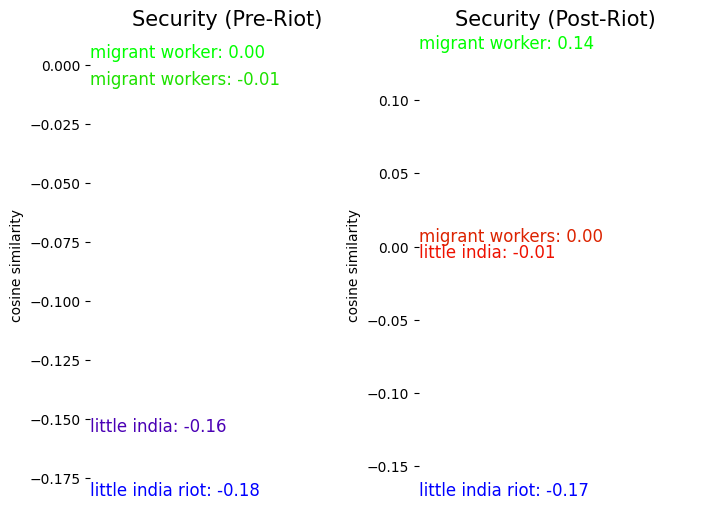

In [216]:
new_secure = securelevels.sort_values('secure_connotation')
new_secure = pd.concat([new_secure.head(5), new_secure.tail(5)])
new_secure['secure_connotation']= new_secure['secure_connotation'].apply(lambda x: -(x**2) if x  <0 else (x**2) )
new_secure.index = topic_names_secure
new_secure = pd.concat([new_secure, pd.DataFrame(topic_names_secure, index = new_secure.index)], axis = 1)

new_moral = morallevels.sort_values('moral_connotation')
new_moral = pd.concat([new_moral.head(5), new_moral.tail(5)])
new_moral['moral_connotation'] = new_moral['moral_connotation'].apply(lambda x: -(x**2) if x  <0 else (x**2))
new_moral.index = topic_names_moral
new_moral = pd.concat([new_moral, pd.DataFrame(topic_names_moral, index = new_moral.index)], axis = 1)

#creating vectors for terms
mwvec_pre =  phrase_vector(['migrant', 'worker'], model_pre) 
mwsvec_pre = phrase_vector(['migrant', 'workers'], model_pre)
livec_pre = phrase_vector(['little', 'india'], model_pre)
lirvec_pre = phrase_vector(['little', 'india', 'riot'], model_pre)

mwvec_post =  phrase_vector(['migrant', 'worker'], model_post) 
mwsvec_post = phrase_vector(['migrant', 'workers'], model_post)
livec_post = phrase_vector(['little', 'india'], model_post)
lirvec_post = phrase_vector(['little', 'india', 'riot'], model_post)

phrase_list = ['migrant worker', 'migrant workers', 'little india', 'little india riot']
phrase_secure_cos_pre = [cosine_similarity(vec.reshape(1, -1), securevec.reshape(1, -1))[0][0] for vec in [mwvec_pre, mwsvec_pre, livec_pre, lirvec_pre]]
phrase_moral_cos_pre = [cosine_similarity(vec.reshape(1, -1), moralvec.reshape(1, -1))[0][0] for vec in [mwvec_pre, mwsvec_pre, livec_pre, lirvec_pre]]
phrase_secure_cos_post = [cosine_similarity(vec.reshape(1, -1), securevec.reshape(1, -1))[0][0] for vec in [mwvec_post, mwsvec_post, livec_post, lirvec_post]]
phrase_moral_cos_post = [cosine_similarity(vec.reshape(1, -1), moralvec.reshape(1, -1))[0][0] for vec in [mwvec_post, mwsvec_post, livec_post, lirvec_post]]

phrase_secure_pre = pd.DataFrame({'secure_connotation': phrase_secure_cos_pre}, index = phrase_list)
phrase_moral_pre = pd.DataFrame({'moral_connotation': phrase_moral_cos_pre}, index = phrase_list)
phrase_secure_post = pd.DataFrame({'secure_connotation': phrase_secure_cos_post}, index = phrase_list)
phrase_moral_post = pd.DataFrame({'secure_connotation': phrase_moral_cos_post}, index = phrase_list)

fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, phrase_secure_pre, 'secure_connotation', 'Security (Pre-Riot)')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, phrase_secure_post, 'secure_connotation', 'Security (Post-Riot)')
plt.show()

### Visualizing Topical Changes 

In [ ]:
uniq = top_topics(high_topics)
unique_topics = uniq[2012] + uniq[2013] + uniq[2014] + uniq [2015]
unique_topics_names = ['Regulation', 'Tragedy', 'Immigration', 'Recession', 'Military', 'Dates', 'Inquiry', 'Disaster', 'Ministers', 'Licensing', 'Upgrading', 'Transformation']
assert len(unique_topics) == len(unique_topics_names)
unique_topics_secure = [cosine_similarity(mydictionary[int(i)].reshape(1,-1), securevec.reshape(1,-1))[0][0] for i in unique_topics]
unique_topics_moral = [cosine_similarity(mydictionary[int(i)].reshape(1,-1), moralvec.reshape(1,-1))[0][0] for i in unique_topics]

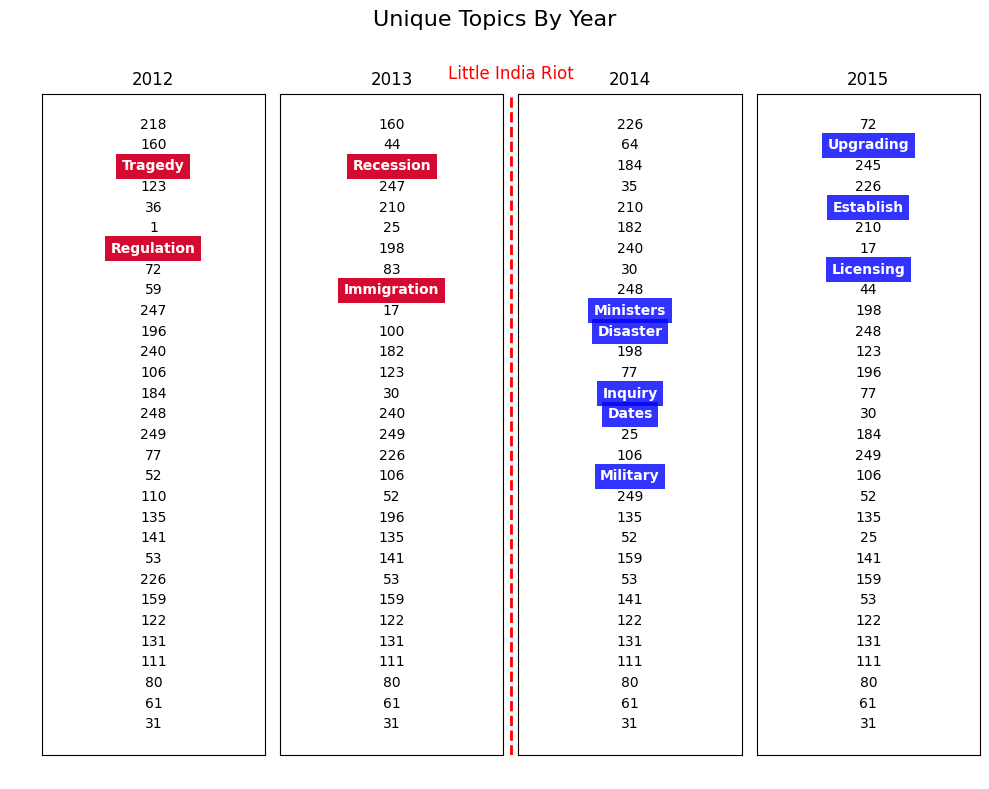

In [68]:
data = {k: high_topics[k] for k in (2012, 2013, 2014, 2015)}
# {k: high_topics[k] for k in ('l', 'm', 'n')}
topics_dict = {21: 'Tragedy', 190: 'Regulation', 130: 'Immigration', 132: 'Recession', 86: 'Military', 105: 'Inquiry', 174: 'Disaster', 232: 'Dates', 124: 'Ministers', 187: 'Upgrading', 39: 'Establish', 230: 'Licensing'}
pre = {21: 'Tragedy', 190: 'Regulation', 130: 'Immigration', 132: 'Recession'}
def get_unique_elements(lst):
    return list(set(lst))

# Define a function to color the unique elements in each column
def color_unique_elements(ax, col_name, col_data, data):
    unique_elements = [topic for year in top_topics(high_topics).keys() for topic in top_topics(high_topics)[year]]
    for i, word in enumerate(col_data) :
        if word in unique_elements and int(word) in topics_dict: 
            ax.text(0.5, i + 0.5, topics_dict[int(word)], ha='center', va='center', color='white', fontsize=10, fontweight='bold', bbox=dict(facecolor='blue', edgecolor='none', alpha=0.8))
            if int(word) in pre: 
                ax.text(0.5, i + 0.5, topics_dict[int(word)], ha='center', va='center', color='white', fontsize=10, fontweight='bold', bbox=dict(facecolor='red', edgecolor='none', alpha=0.8))
        else:
            ax.text(0.5, i + 0.5, word, ha='center', va='center', color='black', fontsize=10)
    ax.set_title(col_name, fontsize=12)
    ax.set_xticks(())
    ax.set_yticks(np.arange(len(col_data)) + 0.5)
    ax.set_yticklabels(col_data, fontsize=10)
    ax.yaxis.set_tick_params(pad=100)
    ax.set_ylim(-1, len(col_data)+1)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    

# Define the figure and axes
fig, axs = plt.subplots(1, len(data), figsize=(10, 8))

# Loop over each column and plot it with the unique elements colored
for i, col_name in enumerate(data):
    col_data = data[col_name]
    color_unique_elements(axs[i], col_name, col_data, data)

middle_line_x = len(data) // 2
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.axvline(middle_line_x, color='red', linestyle='--', linewidth = 2)

# Add the word 'riot' at the bottom of the line
plt.text(middle_line_x, 1.03, 'Little India Riot', ha='center', va='center', fontsize=12, color = 'red')

# Add a title to the whole plot
fig.suptitle('Unique Topics By Year', fontsize=16)

# Adjust the layout and show the plot
fig.tight_layout()
plt.show()

In [105]:
topic_names_secure = ['Terrorism', 'Suffering', 'Cyberattack', 'Unrest', 'Direness', 'Certainty', 'Dates', 'Elderly', 'Welfare', 'Insurance']
topic_names_moral = ['Recession', 'Statistics', 'Trade', 'Threat', 'Taxes', 'Debate', 'Economic Progress',  'Mental Health', 'Commitment', 'Positivity']



In [510]:
morallevels.sort_values('moral_connotation')

,moral_connotation
22,-0.289895
100,-0.255611
26,-0.251497
142,-0.242247
44,-0.222675
...,...
91,0.213891
239,0.232937
137,0.234355
233,0.298861


---
---

---
---

---
---

In [13]:
reconst_qual(twitter_model, dictionary, alpha)

(238.76930258544377, 0.0018173857952312135, 0.10528073477748512)

In [190]:
reconst_qual(parl_model, dictionary_parl, alpha_parl)

(106.06212180202516, 0.0018136423928526617, 0.10906118899161665)

In [201]:
np.shape(parl_df['mean_array'][0][0])

(300,)

In [273]:
def similar_discourse(atoms, arrays): 
    lists = []
    for array in tqdm(arrays): 
        scores = []
        for j, atom in enumerate(atoms):
            scores.append([j, cosine_similarity(np.array(array)[0].reshape(1, -1), atom.reshape(1, -1))])
            scores = sorted(scores, key=lambda x: x[1], reverse=True)
        lists.append([scores[0]])

    return np.squeeze(lists)

In [266]:
def similar_discourse1(atoms, arrays):
    atoms_norm = [1.0 / np.linalg.norm(a) * a for a in atoms]
    lists = []
    for array in tqdm(arrays):
        array = np.array(array)
        array_norm = 1.0 / np.linalg.norm(array) * array
        scores = cosine_similarity(array_norm.reshape(1, -1), atoms_norm)
        max_index = np.argmax(scores)
        lists.append(max_index)
    return lists

In [274]:
parl_scores = similar_discourse(dictionary, parl_df['mean_array'])

100%|██████████| 13005/13005 [05:18<00:00, 40.88it/s]


# Parliamentary Speech

In [5]:
parldata = pd.read_csv('/home/valalvern/thesis/Thesis/models/replication-materials-ValAlvernUChic/hansard_full 2/final_df.csv')

In [19]:
parldata.to_csv('/home/valalvern/thesis/Thesis/files/parldata.csv')

In [18]:
parldata.head()

,Unnamed: 0,year,clean,normalized
0,0,2012,"['the', 'minister', 'for', 'national', 'develo...","[[the, minister, for, national, development, a..."
1,1,2012,"['the', 'minister', 'for', 'national', 'develo...","[[the, minister, for, national, development, i..."
2,2,2012,"['mr', 'speaker', 'with', 'your', 'permission'...","[[mr, speaker, with, your, permission, i, will..."
3,3,2012,"['both', 'the', 'private', 'property', 'and', ...","[[both, the, private, property, and, hdb, resa..."
4,4,2012,"['nonetheless', 'we', 'have', 'seen', 'an', 'u...","[[nonetheless, we, have, seen, an, uptick, in,..."


In [17]:
for row in tqdm(parldata['normalized']):
    i = row[0]
    for j, word in enumerate(i): 
        
        if word == 'migrant-worker': 
            i[j] = 'migrantworker'
        elif(j+1 <len(i)) and word == 'migrant' and i[j + 1] == 'worker':
            i[j] = 'migrantworker'
            i.pop(j + 1)
        elif(j+1 <len(i)) and word == 'foreign' and i[j + 1] == 'worker': 
            i[j] = 'migrantworker'
            i.pop(j + 1)
        elif(j+1 <len(i)) and word == 'foreign' and i[j+1] == 'workers': 
            i[j] = 'migrantworker'
            i.pop(j+1)
        elif (j+1 <len(i)) and word == 'migrant' and i[j + 1] == 'workers': 
            i[j] = 'migrantworker'
            i.pop(j + 1)
        elif (j+1 <len(i)) and word =='little' and i[j + 1] == 'india': 
            i[j] = 'littleindia'
            i.pop(j + 1)
        elif (j+2 < len(i)) and word == 'little' and i[j + 1] == 'india' and i[j + 2] == 'riot': 
            i[j] = 'littleindiariot'
            i.pop(j + 1)
            i.pop(j + 1)
        elif word == 'riot': 
            i[j] = 'littleindiariot'
        
         
        

100%|██████████| 1189940/1189940 [01:07<00:00, 17589.36it/s]


In [16]:
parldata.iloc[0]['normalized'][0]

['the',
 'minister',
 'for',
 'national',
 'development',
 'a',
 'what',
 'is',
 'the',
 'ministrys',
 'assessment',
 'of',
 'the',
 'hdb',
 'resale',
 'price',
 'index',
 'reaching',
 'a',
 'record',
 'level',
 'of',
 '1979',
 'in',
 'the',
 'third',
 'quarter',
 'of',
 '2012',
 'in',
 'spite',
 'of',
 'cooling',
 'measures',
 'and',
 'new',
 'releases',
 'of',
 'bto',
 'flats',
 'b',
 'whether',
 'the',
 'cooling',
 'measures',
 'are',
 'effective',
 'in',
 'managing',
 'property',
 'prices',
 'and',
 'curbing',
 'property',
 'speculation',
 'and',
 'c',
 'what',
 'are',
 'the',
 'ministrys',
 'plans',
 'to',
 'assure',
 'the',
 'public',
 'that',
 'hdb',
 'and',
 'private',
 'properties',
 'will',
 'continue',
 'to',
 'remain',
 'affordable',
 'to',
 'singapore',
 'citizens',
 'and',
 'that',
 'the',
 'ministry',
 'has',
 'a',
 'good',
 'handle',
 'on',
 'the',
 'property',
 'market']

In [8]:
tqdm.pandas()
parldata['normalized'] = parldata['clean'].progress_apply(lambda x: [ast.literal_eval(x)])
#parldata['normalized'] = parldata['normalized'].progress_apply(lambda x: joinwords_parl(x))

100%|██████████| 1189940/1189940 [01:53<00:00, 10453.26it/s]


In [ ]:
def joinwords(y, sent_list = False): 
    """
    Converts 'migrant worker' to one token 
    
    Input: 
        y - list of strings
    
    Returns: 
        string with migrant worker replaced
    """
    if sent_list == True: 
        for word in y:
            if type(y) == float: 
                y = str(y)
            if 'migrant worker' in y:
                return '. '.join([x.replace('migrant worker', 'migrantworker') for x in y.split('. ') if 'migrant worker' in x])
            elif 'migrant workers' in y: 
                return '. '.join([x.replace('migrant workers', 'migrantworker') for x in y.split('. ') if 'migrant workers' in x])
            elif 'little india' in y: 
                return '. '.join([x.replace('little india', 'littleindia') for x in y.split('. ') if 'little india' in x])
            elif 'little india riot' in y: 
                return '. '.join([x.replace('little india', 'littleindiariot') for x in y.split('. ') if 'little india riot' in x])
            else: 
                return y
    else: